# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn import metrics

# Importing the dataset

In [2]:
data = pd.read_csv('sentiment.tsv', sep='\t')
data.head(1)

,label,text
0,neg,"@jamielewislewis i cant believe it, it really ..."


# Cleaning the dataset

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
data.head()

,label,text
0,0,"@jamielewislewis i cant believe it, it really ..."
1,1,having a vodka tonic and looking forward to go...
2,1,@ddlovatofans1neg1 Could you follow me please....
3,1,@jordanknight for once.................. PLEAS...
4,0,Had a dream about a walk in fast food resturau...


# Remove twitter handles(@user)

In [4]:
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

data['tidy_text'] = np.vectorize(remove_pattern)(data['text'], '@[\w]*') 
data.head(5)

,label,text,tidy_text
0,0,"@jamielewislewis i cant believe it, it really ...","i cant believe it, it really doesnt belong th..."
1,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
2,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...
3,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...
4,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...


# Remove special characters, numbers, punctuations

In [5]:
data['tidy_text'] = data['tidy_text'].str.replace(r'[^a-zA-Z#]', ' ')
data.head()

,label,text,tidy_text
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believe it it really doesnt belong th...
1,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
2,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please I would really app...
3,1,@jordanknight for once.................. PLEAS...,for once PLEASE TELL US WHY...
4,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...


# Tokenize the tweets

In [6]:
tokenized_tweet = data['tidy_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [i, cant, believe, it, it, really, doesnt, bel...
1    [having, a, vodka, tonic, and, looking, forwar...
2    [Could, you, follow, me, please, I, would, rea...
3    [for, once, PLEASE, TELL, US, WHY, u, were, th...
4    [Had, a, dream, about, a, walk, in, fast, food...
Name: tidy_text, dtype: object

In [7]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
stemmed_text = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
stemmed_text.head(5)

0    [i, cant, believ, it, it, realli, doesnt, belo...
1    [have, a, vodka, tonic, and, look, forward, to...
2    [could, you, follow, me, pleas, I, would, real...
3    [for, onc, pleas, tell, US, whi, u, were, thin...
4    [had, a, dream, about, a, walk, in, fast, food...
Name: tidy_text, dtype: object

# Joining the tokenized word in the same data

In [8]:
for i in range(len(stemmed_text)):
        stemmed_text[i] = ' '.join(stemmed_text[i])
data['tidy_text'] = stemmed_text
data.head()

,label,text,tidy_text
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believ it it realli doesnt belong there...
1,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...
2,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...
3,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...
4,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...


# Adding other column for length of the tweet and punctuation

In [9]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(' ')),3)*100

In [10]:
data['body_len'] = data['tidy_text'].apply(lambda x: len(x)-x.count(' '))
data['body_len'].replace(0, np.nan, inplace=True)
data.dropna(inplace=True)
data['punc%'] = data['tidy_text'].apply(lambda x: count_punct(x))

In [11]:
def hashtag_extract(x):
    hashtag = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtag.append(ht)
    return hashtag

In [12]:
# extract hash from no racist/sexist tweets
HT_regular = hashtag_extract(data['tidy_text'][data['label']==0])
# positive
HT_negative = hashtag_extract(data['tidy_text'][data['label']==1])
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

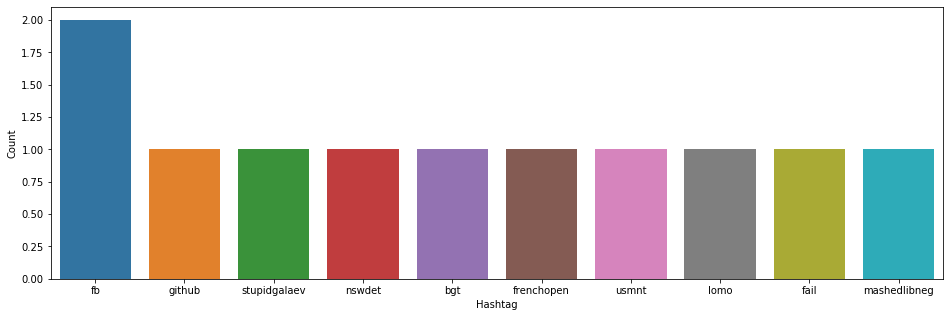

In [13]:
import nltk 

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()

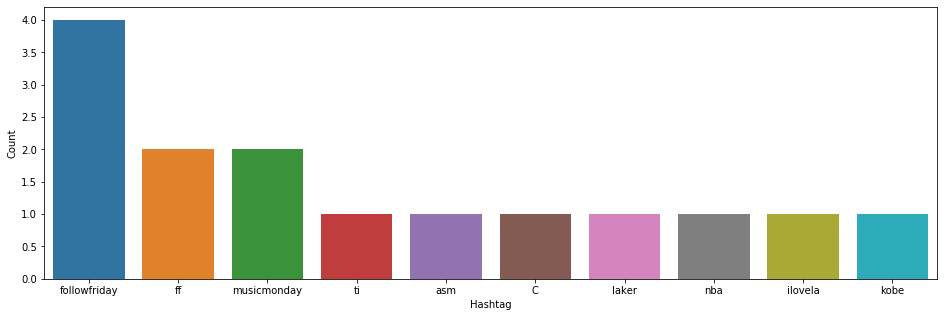

In [14]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag':list(a.keys()),
                 'count':list(a.values())})
d = d.nlargest(columns = "count",n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d,x = 'Hashtag', y = "count")
ax.set(ylabel = 'Count')
plt.show()

 # Feature selection and engineering

# Count Vectorizer

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')
vect = count_vect.fit_transform(data['tidy_text'])
new_vect_df = pd.concat([data['body_len'], data['punc%'], pd.DataFrame(vect.toarray()), data['label']], axis=1)
new_vect_df.head()

,body_len,punc%,0,1,2,3,4,5,6,7,...,3936,3937,3938,3939,3940,3941,3942,3943,3944,label
0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TfidfVectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words='english')
vect = tfidf_vect.fit_transform(data['tidy_text'])
new_tfidf_vect = pd.concat([data['body_len'],data['punc%'],pd.DataFrame(vect.toarray()),data['label']],axis = 1)
new_tfidf_vect.head()

,body_len,punc%,0,1,2,3,4,5,6,7,...,3936,3937,3938,3939,3940,3941,3942,3943,3944,label
0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Testing Algorithm

In [17]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [18]:
model = []
model.append(('LR',LogisticRegression()))
model.append(('RF',RandomForestClassifier()))
model.append(('GB',GradientBoostingClassifier()))
model.append(('DT',DecisionTreeClassifier()))
model.append(('NB',GaussianNB()))
model.append(('KNN',KNeighborsClassifier()))
model.append(('SVC',SVC()))

# 10 fold crossvalidation

In [19]:
new_vect_df.dropna(inplace=True)
x = new_vect_df.drop('label', axis=1)
y = new_vect_df['label']
for name, clf in model:
    scores = cross_val_score(clf, x, y, scoring='accuracy', cv=10)
    print('Model Name: %s and Score %f'%(name, scores.mean()))

/media/primz/Education Content/Prime/ML/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/primz/Education Content/Prime/ML/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model Name: LR and Score 0.496719
Model Name: RF and Score 0.489193
Model Name: GB and Score 0.504221
Model Name: DT and Score 0.497759
Model Name: NB and Score 0.493683
Model Name: KNN and Score 0.498249
Model Name: SVC and Score 0.517776


In [194]:
new_tfidf_vect.dropna(inplace=True)
x = new_tfidf_vect.drop('label', axis=1)
y = new_tfidf_vect['label']
for name, clf in model:
    scores = cross_val_score(clf, x, y, scoring='accuracy', cv=10)
    print('Model Name: %s and Score %f'%(name, scores.mean()))

/media/primz/Education Content/Prime/ML/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/media/primz/Education Content/Prime/ML/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model Name: LR and Score 0.493216
Model Name: RF and Score 0.502741
Model Name: GB and Score 0.465118
Model Name: DT and Score 0.493721
Model Name: NB and Score 0.504741
Model Name: KNN and Score 0.487671
Model Name: SVC and Score 0.516776


# SVC Tuning

In [20]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.1, 1]
    gammas = [0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [21]:
svc_param_selection(x, y, 10)

{'C': 0.1, 'gamma': 1}

# Data Selection

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
x_train.shape, x_test.shape

((1594, 3947), (399, 3947))

In [32]:
classifier = SVC(kernel='rbf', gamma=1, C=0.1)
classifier.fit(x_train, y_train)
print('Traning Score', classifier.score(x_train, y_train))

Traning Score 0.5031367628607277


In [35]:
y_pred = classifier.predict(x_test)
print('Testing Score', accuracy_score(y_test, y_pred))

Testing Score 0.49373433583959897


In [26]:
print('F1 Score',f1_score(y_test, y_pred))

F1 Score 0.6610738255033557


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[197,   0],
       [202,   0]])